In [1]:
from Assemblies.game import GameField
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
eps = 0.01
bs = 9/5+eps
L = 300
cp = 50

offp = np.linspace(80,0,num=20,dtype=int)

seeds = np.zeros(100,dtype=int)
for i in range(100):
    seeds[i] = i + 1

    
#информации по шагам отжига и эволюции я в статье не нашёл, поэтому пусть будет 1800 и 500 соответственно
burnin1 = 1800
evol1 = 500

In [4]:
#плотность для конкретного b
def c_density(size, coop_percentage, off_percentage, seed, burnin, evol, b): 
    np.random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    #здесь active означает места, занятые кооператорами или дефекторами
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    density = np.zeros(evol)
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(burnin)
    for step in range(evol):
        game.evolveQ(1)
        density[step] = np.count_nonzero(np.equal(game.field,0)) / len(active)
    return density

In [5]:
#измеряем плотность для одной реализации на протяжении evol1 шагов. 
#усредняем по шагам.

#функция возвращает массив плотности по значениям off_percentage для определённого процента кооператоров и определённого b
def total_density(size, coop_percentage, off_percentage, seed, burnin, evol, b):
    
    aver_all=np.zeros(len(off_percentage))
    for i in range(len(off_percentage)):
        den=np.zeros(evol)
        den=c_density(size, coop_percentage, off_percentage[i], seed, burnin, evol, b)
        aver_all[i]=np.mean(den)

    return aver_all 

In [6]:
#среднее по времени
den300 = np.zeros((len(seeds), len(offp)))
for i in range(len(seeds)):
    den300[i] = total_density(size=L, coop_percentage=cp, off_percentage=offp, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

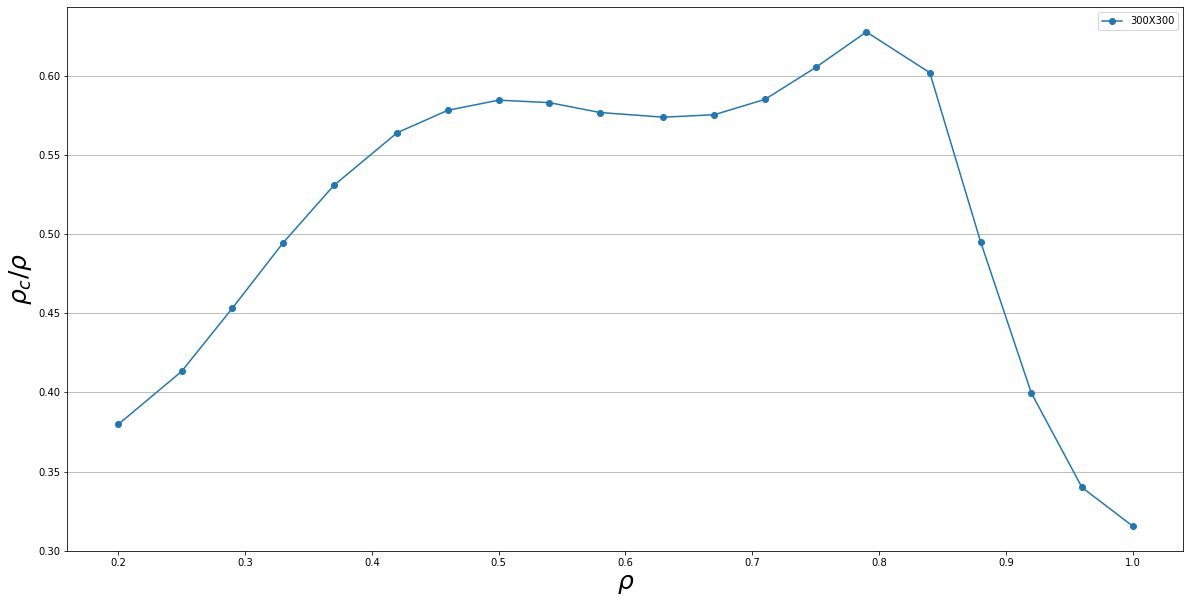

In [7]:
#среднее по реализациям
aver300 = np.mean(den300, axis=0)
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')

ax.plot(1-offp*0.01, aver300, 'o-', label='300X300')
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()

# Вблизи пика

In [8]:
#вблизи p* для 300x300
offp_close = np.linspace(23, 15, num=17, dtype=float)

#среднее по времени
den_close300 = np.zeros((len(seeds), len(offp_close)))

for i in range(len(seeds)):
    den_close300[i] = total_density(size=L, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

In [9]:
#среднее по реализациям
aver_close300 = np.mean(den_close300, axis=0)

errs300 = np.zeros(len(aver_close300))
for i in range(len(aver_close300)):
    errs300[i] = np.sqrt(sum((aver_close300[i] - den_close300[::, i]) ** 2) / len(aver_close300))

In [10]:
#вблизи p* для 100x100
den_close100 = np.zeros((len(seeds), len(offp_close)))
for i in range(len(seeds)):
    den_close100[i] = total_density(size=100, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

In [11]:
aver_close100 = np.mean(den_close100, axis=0)
errs100 = np.zeros(len(aver_close100))
for i in range(len(aver_close100)):
    errs100[i] = np.sqrt(sum((aver_close100[i] - den_close100[::, i]) ** 2) / len(aver_close100))

In [12]:
#вблизи p* для 200x200
den_close200 = np.zeros((len(seeds), len(offp_close)))
for i in range(len(seeds)):
    den_close200[i] = total_density(size=200, coop_percentage=cp, off_percentage=offp_close, seed=seeds[i], burnin=burnin1, evol=evol1, b=bs)

KeyboardInterrupt: 

In [ ]:
aver_close200 = np.mean(den_close200, axis=0)
errs200 = np.zeros(len(aver_close200))
for i in range(len(aver_close200)):
    errs200[i] = np.sqrt(sum((aver_close200[i] - den_close200[::, i]) ** 2) / len(aver_close200))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.grid(b=True,axis='y')
#scale = 10
#plt.clf()
#plt.figure(figsize = (scale, scale))

ax.errorbar(1-offp_close*0.01, aver_close300, yerr=errs300, fmt='o-', capsize=3, label='300X300')
ax.errorbar(1-offp_close*0.01, aver_close200, yerr=errs200, fmt='o-', capsize=3, label='200X200')
ax.errorbar(1-offp_close*0.01, aver_close100, yerr=errs100, fmt='o-', capsize=3, label='100X100')
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend()

No handles with labels found to put in legend.


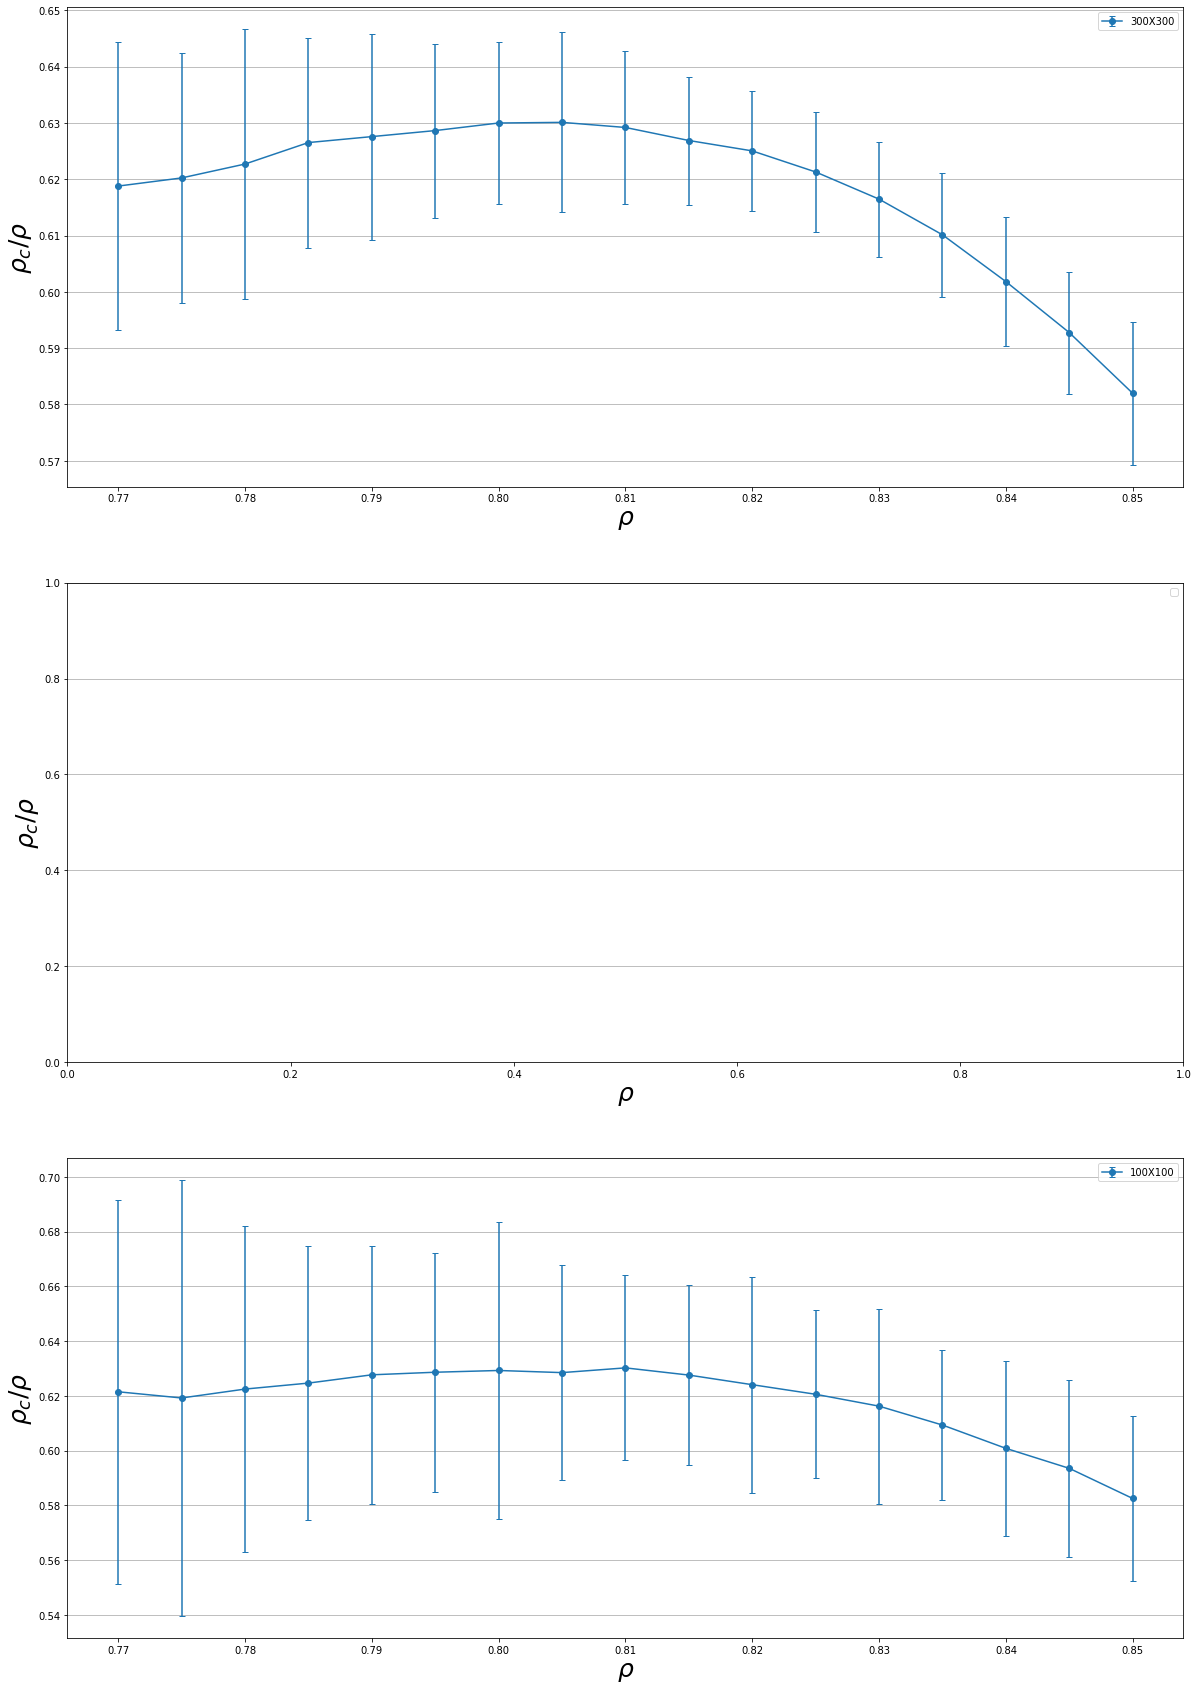

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,30))
#scale = 10
#plt.clf()
#plt.figure(figsize = (scale, scale))

ax1.errorbar(1-offp_close*0.01, aver_close300, yerr=errs300, fmt='o-', capsize=3, label='300X300')
#ax2.errorbar(1-offp_close*0.01, aver_close200, yerr=errs200, fmt='o-', capsize=3, label='200X200')
ax3.errorbar(1-offp_close*0.01, aver_close100, yerr=errs100, fmt='o-', capsize=3, label='100X100')
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
    ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
    ax.legend()
    ax.grid(b=True,axis='y')

In [15]:
maxind300=np.argmax(aver_close300)
p_star=(100-offp_close)[maxind300]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  80.5


In [ ]:
maxind200=np.argmax(aver_close200)
p_star=(100-offp_close)[maxind200]
print('критический процент заполненности решётки p* = ', p_star)

In [16]:
maxind100=np.argmax(aver_close100)
p_star=(100-offp_close)[maxind100]
print('критический процент заполненности решётки p* = ', p_star)

критический процент заполненности решётки p* =  81.0


## Persistence

In [12]:
#массив значений persistence на протяжении t-tw шагов для определённой реализации игры
def persistence(size, coop_percentage, off_percentage, seed, b, t, tw):
    random.seed(seed)
    instance = np.array(np.random.rand(size, size) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes=(-1-instance).nonzero()
    active_size=active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    instance[active_indexes]=np.copy(active)
    
    c=active_size
    persistence=np.zeros(t-tw)
    
    #флаги индексы элементов
    #0 - прошёл проверку на неизменность стратегий, 1 - не прошёл
    dropout_flags=np.zeros(active_size, dtype=int) 
    
    game = GameField(size, b)
    game.field = np.copy(instance)
    game.evolveQ(tw)
    for step in range(t-tw):
        game.evolveQ(1)
        
        evolution=np.copy(game.field[active_indexes])
        
        for i in range(len(evolution)):
            if (dropout_flags[i]!=1) and (evolution[i]!=active[i]):
                c-=1
                dropout_flags[i]=1
        
        persistence[step]=c/active_size
    return persistence

In [16]:
points_close=np.linspace(80, 88, num=40, dtype=float)
t1=1000
tw1=0

pers_close=np.zeros((len(seeds), len(points_close)))
for j in range(len(seeds)):
    for i in range(len(points_close)):
        pers_close[j][i]=persistence(size=L,coop_percentage=cp,off_percentage=100 - points_close[i],seed=seeds[j],b=bs,t=t1,tw=tw1)[-1]
        
all_pers_close = np.mean(pers_close, axis=0)